# Question 6

### I.
#### Load data

In [8]:
# load training and test dataset into dataframe
train <- read.csv(file="Task1D_train.csv", header=TRUE, sep=",")
test <- read.csv(file="Task1D_test.csv", header=TRUE, sep=",")

train.len <- nrow(train)
test.len <- nrow(test)

head(train)

x1,x2,x3,x4,y
5.1,3.5,1.4,0.2,C1
4.7,3.2,1.3,0.2,C1
5.0,3.6,1.4,0.2,C1
4.6,3.4,1.4,0.3,C1
4.4,2.9,1.4,0.2,C1
5.4,3.7,1.5,0.2,C1


#### Split into predictors and label

In [9]:
# split the datai into predictors and target variable
train.data <- train[, 1:4]
train.label <- as.matrix(train[,5])
test.data <- test[, 1:4]
test.label <- as.matrix(test[,5])

In [10]:
unique(train.label)

C1
C2
C3


There are 3 classes, therefore 3 weight vectors need to be created. I am using a 3 dimensional array to store these vectors.

#### II.
#### Initialize parameters

In [19]:
## Basis function (Step 1)
Phi <- as.matrix(cbind(1, train.data)) # add a column of 1 as phi_0
Phi_test <- as.matrix(cbind(1, test.data)) # add a column of 1 as phi_0

# set learning rate
eta <- 0.09

# stop criterion
epsilon <- 0.001
# maximum number of iterations
tau.max <- 150

# True label for training set (get substring and change to number)
T <- as.matrix(as.numeric(substr(train.label, 2, 2)))
T_test <- as.matrix(as.numeric(substr(test.label, 2, 2)))

# create 3 dimensional array and initialize weight vector randomly
W<-array(0,dim=c(3,nrow = (tau.max),ncol(Phi)))
W[1,1,] <- runif(ncol(Phi))
W[2,1,] <- runif(ncol(Phi))
W[3,1,] <- runif(ncol(Phi))

# Placeholder for errors
error.trace <- matrix(0,nrow = tau.max , ncol=1)
error.test <- vector()

# iteration counter 
tau <- 1 
# termination status
terminate <- FALSE

#### Calculate initial error

In [20]:
# calculate initial error
pred <- as.matrix(max.col(t(W[,1,] %*% t(Phi))))

error.trace[1,] <- sum(ifelse(pred == T, 0,1))/train.len * 100

#### III.
#### Main Loop

In [21]:
# Main Loop (Step 2):
while(!terminate){
    # resuffling train data and associated labels:
    train.index <- sample(1:train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index]

    for (i in 1:train.len){
        if (tau == tau.max) {break}
        
        # Make prediction
        predict <- which.max(W[,tau,] %*% Phi[i,])

        # if prediction is not equal to label, update weight
        if (predict != T[i]){
            W[predict,tau+1,] <- W[predict, tau,] - eta * Phi[i,]
            W[T[i], tau+1,] <- W[T[i], tau,] + eta * Phi[i,] 
            
            # simply copy the weight of the remaining class without any update
            c_list <- c(1,2,3)
            c_list <- c_list[!c_list == predict]
            c_list <- c_list[!c_list == T[i]]
            
            W[c_list, tau+1,] <- W[c_list, tau, ]
            # increment tau
            tau <- tau +1
            
            # calculate train error
            pred_all <- as.matrix(max.col(t(W[,tau,] %*% t(Phi))))
            error.trace[tau] <- sum(ifelse(pred_all == T, 0,1))/train.len * 100
            
            # decrease eta:
            eta <- eta * 0.999
        }
        # for every 5 datapoints, calculate test error
        if (i%%5 == 0){
            pred_test <- as.matrix(max.col(t(W[,tau,] %*% t(Phi_test))))
            error.test <- append( error.test, sum(ifelse(pred_test == T_test, 0,1))/test.len * 100)
        }
        

    }

    terminate <- tau >= tau.max

}
W <- W[,1:tau,] # cut the empty part of the matrix (when the loop stops before tau == tau.max)

Most of the code is adopted from tutorial, however there are some variations regarding to the stopping conditions. I decide to decrease the learning rate after each update since I found the performance of the model is better, I also increase the number of iteration to 150 and I removed the stopping condition using epsilon. The stopping condition is only controlled by the tau.max variable.

In [22]:
# construct dataframe to store test error
df_error_test <- data.frame(cbind(1:nrow(as.matrix(error.test)), as.matrix(error.test)))
colnames(df_error_test) <- c('mini_batch', 'error_rate')

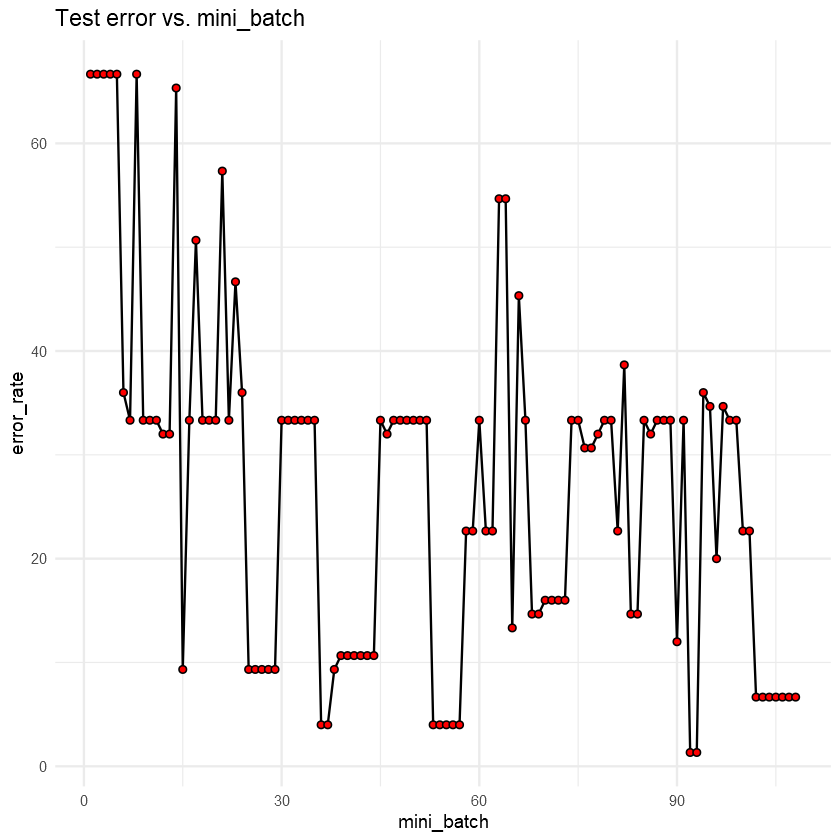

In [23]:
library(ggplot2)

# plot test error
ggplot(data=df_error_test,aes(x=mini_batch, y=error_rate)) + geom_line() + geom_point(shape=21, fill='red')  +
    ggtitle('Test error vs. mini_batch') + theme_minimal()